# 02. Feature Engineering & Baseline Model

**Project:** Swiss Rental Price Prediction<br>
**Author:** Dimitrios Mylonas

**Objective:**
The goal of this notebook is to bridge the gap between raw data and Machine Learning. We will enrich the dataset with domain-specific features (Geospatial, NLP, and Economic data) and establish a statistical baseline using Ridge Regression.

**Methodology:**
1.  **Geospatial Engineering:** Calculate "Commute Distance" to major Swiss economic hubs (Zurich, Geneva, Basel, Bern, Lausanne).
2.  **NLP Feature Extraction:** Parse description text for value-add keywords (e.g., "Lake View", "Penthouse", "Quiet").
3.  **Economic Data Augmentation:** Integrate external tax data (Municipal Tax Multipliers) to capture the "Zug Effect" (Low tax = High rent).
4.  **Strict Data Splitting:** Perform Train/Test split *before* encoding to prevent Data Leakage.
5.  **Baseline Modeling:** Train a Ridge Regression model to set the benchmark MAE (Mean Absolute Error).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import category_encoders as ce 

# Configuration
pd.set_option('display.max_columns', None)
%matplotlib inline
sns.set_style("whitegrid")

# Load Cleaned Data
df = pd.read_pickle('../data/processed/01_cleaned_data.pkl')
print(f"Data loaded: {df.shape}")

Data loaded: (16005, 26)


## 1. Feature Engineering

### 1.1 Geospatial Features (Distance to Hubs)
In Switzerland, rent is heavily correlated with proximity to major employment centers. We calculate the Haversine distance (as the crow flies) to the "Big 5" cities.

In [2]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculates the great circle distance between two points 
    on the earth (specified in decimal degrees) in km.
    """
    R = 6371  # Radius of earth in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Coordinates of major Swiss hubs
hubs = {
    'Zurich_HB': (47.378177, 8.540192),
    'Geneva_Cornavin': (46.210226, 6.142456),
    'Basel_SBB': (47.547412, 7.589556),
    'Bern_HB': (46.948833, 7.439122),
    'Lausanne_Gare': (46.516777, 6.629095)
}

# Apply calculation
for city, (lat_c, lon_c) in hubs.items():
    df[f'dist_to_{city}'] = haversine_distance(df['Lat'], df['Lon'], lat_c, lon_c)

# Create a 'min_dist_to_hub' feature (Distance to the closest major city)
df['dist_to_closest_hub'] = df[[f'dist_to_{city}' for city in hubs]].min(axis=1)

print("Geospatial features created.")

Geospatial features created.


### 1.2 NLP Feature Extraction
The `Description` field often contains details that structured columns miss. We extract boolean flags for high-value keywords in German, French, and English.

In [3]:
# Keywords for "Luxury/Special" features
keywords = {
    'has_lake_view': ['see', 'lac', 'lake', 'sicht', 'vue', 'view'],
    'is_attic': ['attika', 'attique', 'penthouse', 'dachwohnung'],
    'is_quiet': ['ruhig', 'calme', 'quiet'],
    'is_sunny': ['sonnig', 'ensoleillé', 'sunny']
}

def check_keywords(text, words):
    if not isinstance(text, str):
        return 0
    text = text.lower()
    for w in words:
        if w in text:
            return 1
    return 0

for feature_name, word_list in keywords.items():
    df[feature_name] = df['Description'].apply(lambda x: check_keywords(x, word_list))

print("NLP features created. Summary of findings:")
display(df[list(keywords.keys())].sum())

NLP features created. Summary of findings:


has_lake_view    7757
is_attic          862
is_quiet         4823
is_sunny         1980
dtype: int64

### 1.3 External Data Augmentation: Municipal Tax Burdens
Rent in Switzerland is inversely correlated with taxes (The "Zug Effect"). We integrate 2025 tax data.
*   **Method:** We merge scraped rental data with external tax records based on City Name.
*   **Fallback:** If a City name doesn't match (e.g., spelling differences), we fall back to the median tax rate of the Canton.

In [4]:
import sys
import os

# Add 'src' to the python path
sys.path.append(os.path.abspath('../src'))

# Import mappings
try:
    from mappings import CITY_TO_COMMUNE_MAP
    print("Successfully imported CITY_TO_COMMUNE_MAP from src/mappings.py")
except ImportError:
    print("Warning: could not import mappings. Using empty manual map.")
    CITY_TO_COMMUNE_MAP = {}

# Load external tax data
try:
    tax_df = pd.read_csv('../data/external/tax_data_2025.csv')
    tax_df['tax_rate'] = tax_df['income_tax_canton'] + tax_df['income_tax_commune']
    
    # Pre-calculate Canton Medians
    canton_medians = tax_df.groupby('canton')['tax_rate'].median().to_dict()

    def normalize_name(name):
        """Standardizes Swiss city names"""
        if not isinstance(name, str): return ''
        name = name.lower().strip()
        name = name.replace('ü', 'ue').replace('ä', 'ae').replace('ö', 'oe')
        name = name.replace('è', 'e').replace('é', 'e').replace('à', 'a')
        name = name.replace('sankt ', 'st ').replace('st.', 'st')
        return name.split('(')[0].strip()

    # Create Lookup Dictionary
    tax_df['lookup_key'] = tax_df['commune'].apply(normalize_name) + "_" + tax_df['canton'].str.lower().str.strip()
    tax_map = dict(zip(tax_df['lookup_key'], tax_df['tax_rate']))

    def get_tax_rate_smart(row):
        """Returns (tax_rate, status_code)"""
        # 0 = Exact Match, 1 = Manual Map, 2 = Fallback
        
        city_raw = str(row['City'])
        city_norm = normalize_name(city_raw)
        canton_norm = str(row['Canton']).lower().strip()
        
        # 1. Check Manual Map
        if city_norm in CITY_TO_COMMUNE_MAP:
            mapped_name = normalize_name(CITY_TO_COMMUNE_MAP[city_norm])
            key = f"{mapped_name}_{canton_norm}"
            if key in tax_map: return tax_map[key], "Mapped Match"
            
        elif city_raw.lower() in CITY_TO_COMMUNE_MAP:
            mapped_name = normalize_name(CITY_TO_COMMUNE_MAP[city_raw.lower()])
            key = f"{mapped_name}_{canton_norm}"
            if key in tax_map: return tax_map[key], "Mapped Match"

        # 2. Check Exact Match
        key = f"{city_norm}_{canton_norm}"
        if key in tax_map:
            return tax_map[key], "Exact Match"
        
        # 3. Fallback
        canton_upper = row['Canton'].upper()
        if canton_upper in canton_medians:
            return canton_medians[canton_upper], "Fallback (Canton Median)"
            
        return 100.0, "Fallback (Global)"

    # Apply and split result
    temp_res = df.apply(get_tax_rate_smart, axis=1)
    df['tax_rate'] = [x[0] for x in temp_res]
    df['tax_source'] = [x[1] for x in temp_res] # Temporary column for report

    # --- VALIDATION REPORT ---
    print("\n" + "="*40)
    print("TAX MERGE REPORT")
    print("="*40)
    print(df['tax_source'].value_counts())
    
    print("\nTop 10 Cities defaulting to Canton Median:")
    mismatches = df[df['tax_source'].str.contains("Fallback")]
    if not mismatches.empty:
        print(mismatches['City'].value_counts().head(10))
    else:
        print("None! 100% Match.")
    print("="*40)

    # Optional: Drop the source column to keep dataset clean
    # df = df.drop(columns=['tax_source']) 

except FileNotFoundError:
    print("Warning: Tax CSV not found.")
    df['tax_rate'] = 100.0
except Exception as e:
    print(f"Error: {e}")

Successfully imported CITY_TO_COMMUNE_MAP from src/mappings.py

TAX MERGE REPORT
tax_source
Exact Match                 11897
Mapped Match                 3453
Fallback (Canton Median)      655
Name: count, dtype: int64

Top 10 Cities defaulting to Canton Median:
City
Bramois           6
Sementina         6
Argnou (Ayent)    6
Anzère            6
Cormérod          5
Ebmatingen        5
Pfaffhausen       5
St-Blaise         5
Cormagens         5
Werdenberg        5
Name: count, dtype: int64


## 2. Data Splitting
We split the data *before* any Target Encoding or Scaling. This prevents "Data Leakage" (information from the test set leaking into the training process).

In [5]:
# Drop columns not needed for modeling
drop_cols = ['ID', 'Description', 'City', 'Date_Created', 'Link', 'Title', 'tax_source'] 
# Note: Added 'tax_source' to drop_cols so it doesn't leak into the model

model_df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# 1. Separate Features and Target
X = model_df.drop(columns=['Rent'])
y = model_df['Rent']

# 2. Split (80/20)
# We split the RAW target (y) first. We will log-transform inside the training section.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train Shape: {X_train.shape}")
print(f"Test Shape:  {X_test.shape}")

Train Shape: (12804, 33)
Test Shape:  (3201, 33)


## 3. Preprocessing Pipeline
We build a Scikit-Learn pipeline to handle different data types:
*   **Numerical:** Scale using `StandardScaler` (Linear models require this).
*   **Categorical (Low Cardinality):** `OneHotEncoder` for `Canton`, `SubType`.
*   **Categorical (High Cardinality):** `TargetEncoder` for `Zip`.

In [6]:
# Define column groups
num_features = [
    'Rooms', 'Area_m2', 'Floor', 'Lat', 'Lon',
    'dist_to_Zurich_HB', 'dist_to_Geneva_Cornavin', 'dist_to_Basel_SBB', 
    'dist_to_Bern_HB', 'dist_to_Lausanne_Gare', 'dist_to_closest_hub',
    'tax_rate'
]
binary_features = [
    'is_rent_estimated', 'year_built_is_missing', 'is_renovated',
    'Balcony', 'Elevator', 'Parking', 'View', 'Fireplace', 
    'Child_Friendly', 'CableTV', 'New_Building', 'Minergie', 'Wheelchair',
    'has_lake_view', 'is_attic', 'is_quiet', 'is_sunny'
]
cat_features_onehot = ['Canton', 'SubType']
cat_features_target = ['Zip']

# Create Transformers
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
target_transformer = ce.TargetEncoder(cols=['Zip'])

# Combine into Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat_onehot', categorical_transformer, cat_features_onehot),
        ('cat_target', target_transformer, cat_features_target),
        ('bin', 'passthrough', binary_features) # Don't scale binary flags
    ]
)

print("Preprocessing pipeline constructed.")

Preprocessing pipeline constructed.


## 4. Baseline Model (Ridge Regression)
We use Ridge Regression (Linear Regression with L2 Regularization).
*   **Metric:** We focus on **MAE (Mean Absolute Error)** because it represents the average error in Swiss Francs (CHF), which is easy to explain to stakeholders.

In [7]:
# 1. Define the Pipeline
baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

# 2. Log Transform the Target (Training Data Only)
y_train_log = np.log1p(y_train)

# 3. Train the Model
print("Training Baseline Model on Log-Transformed Target...")
baseline_pipeline.fit(X_train, y_train_log)

# 4. Predict
# Note: The model outputs LOG prices. We must inverse transform them.
y_pred_log = baseline_pipeline.predict(X_test)
y_pred_final = np.expm1(y_pred_log)  # Inverse Log (Exponential)

# 5. Evaluate
# Compare our predicted CHF values against the actual CHF test set
mae_test = mean_absolute_error(y_test, y_pred_final)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_final))
r2_test = r2_score(y_test, y_pred_final)

print("-" * 30)
print(f"Baseline Performance (Log-Transformed):")
print(f"MAE Test:  {mae_test:.2f} CHF  <-- Key Metric")
print(f"RMSE Test: {rmse_test:.2f} CHF")
print(f"R2 Score:  {r2_test:.4f}")
print("-" * 30)

Training Baseline Model on Log-Transformed Target...
------------------------------
Baseline Performance (Log-Transformed):
MAE Test:  579.44 CHF  <-- Key Metric
RMSE Test: 1031.95 CHF
R2 Score:  0.5919
------------------------------


## 5. Error Analysis
Understanding *where* the baseline fails helps us improve the next model.

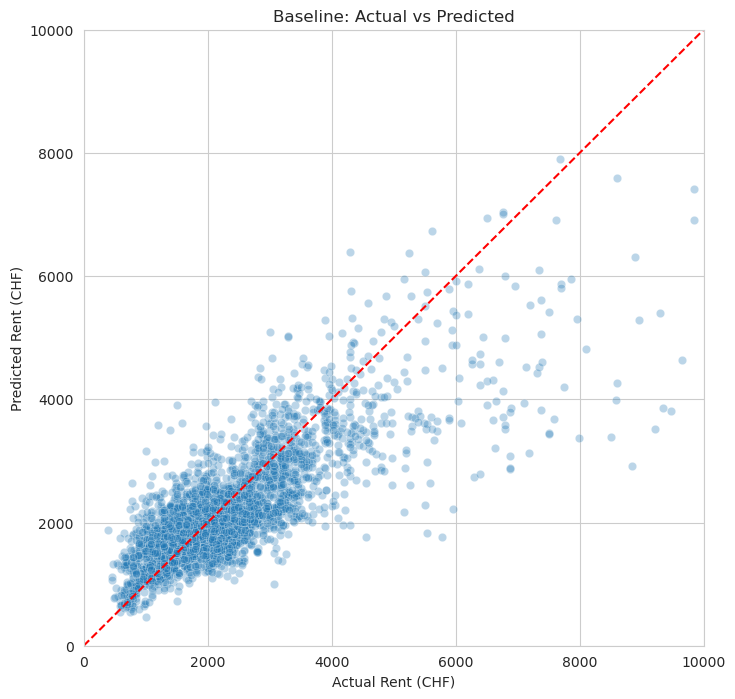

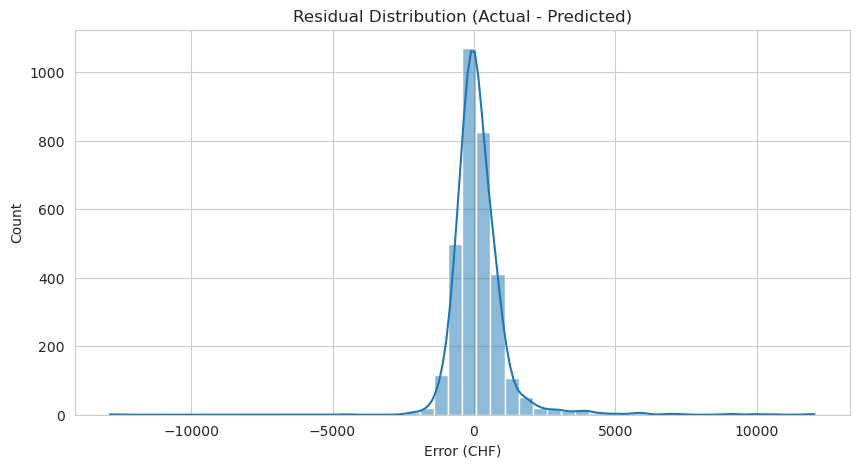

In [8]:
# 1. Predicted vs Actual
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_final, alpha=0.3)
plt.plot([0, 10000], [0, 10000], 'r--') # Perfect prediction line
plt.xlabel('Actual Rent (CHF)')
plt.ylabel('Predicted Rent (CHF)')
plt.title('Baseline: Actual vs Predicted')
plt.xlim(0, 10000)
plt.ylim(0, 10000)
plt.show()

# 2. Residual Distribution
residuals = y_test - y_pred_final
plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Residual Distribution (Actual - Predicted)')
plt.xlabel('Error (CHF)')
plt.show()

## 6. Export for Machine Learning
We save the feature-engineered dataset. Note: We save the *DataFrame*, not the numpy arrays. This allows us to use different encoding strategies (like native categorical handling) in our Tree Models (XGBoost) in the next notebook.

In [9]:
# Re-assemble the dataframe for export
# (We already have model_df, but let's be safe and ensure Rent is the original y)
model_df['Rent'] = y 

# Save to Pickle
model_df.to_pickle('../data/processed/02_featured_data.pkl')
print("Feature-engineered dataset saved successfully.")

Feature-engineered dataset saved successfully.
